In [ ]:
!pip install duckdb --quiet

In [ ]:
import pandas as pd
%load_ext duckdb
import duckdb
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, anderson, jarque_bera, poisson, norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import f_oneway, ttest_ind, chi2_contingencyimport
import numpy
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')


The duckdb module is not an IPython extension.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

In [ ]:
trip_df = pd.read_csv('/content/drive/MyDrive/Yellow_Taxi_Trip_Data.csv')
zone_df = pd.read_csv('/content/drive/MyDrive/taxi_zone_lookup.csv')

In [ ]:
trip_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


In [ ]:
zone_df.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [ ]:
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   VendorID               1197616 non-null  float64
 1   tpep_pickup_datetime   1200000 non-null  object 
 2   tpep_dropoff_datetime  1200000 non-null  object 
 3   passenger_count        1197616 non-null  float64
 4   trip_distance          1200000 non-null  float64
 5   RatecodeID             1197616 non-null  float64
 6   store_and_fwd_flag     1197616 non-null  object 
 7   PULocationID           1200000 non-null  int64  
 8   DOLocationID           1200000 non-null  int64  
 9   payment_type           1197616 non-null  float64
 10  fare_amount            1200000 non-null  float64
 11  extra                  1200000 non-null  float64
 12  mta_tax                1200000 non-null  float64
 13  tip_amount             1200000 non-null  float64
 14  tolls_amount      

In [ ]:
trip_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1.197616e+06,1.197616e+06,1.200000e+06,1.197616e+06,1.200000e+06,1.200000e+06,1.197616e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,1.676147e+00,1.569816e+00,3.074710e+00,1.071696e+00,1.630334e+02,1.611301e+02,1.320138e+00,1.283874e+01,1.049201e+00,4.931589e-01,2.088968e+00,3.741432e-01,2.978805e-01,1.866930e+01,2.258160e+00
std,4.679450e-01,1.182415e+00,4.096253e+00,8.894477e-01,6.604844e+01,7.078979e+01,4.972796e-01,1.284313e+01,1.240537e+00,7.043398e-02,2.841734e+00,1.893830e+00,3.482469e-02,1.553930e+01,7.600723e-01
min,1.000000e+00,0.000000e+00,-2.218000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.238000e+03,-7.000000e+00,-5.000000e-01,-7.000000e+00,-3.000000e+01,-3.000000e-01,-1.242300e+03,-2.500000e+00
25%,1.000000e+00,1.000000e+00,9.800000e-01,1.000000e+00,1.250000e+02,1.070000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.640000e+00,1.000000e+00,1.610000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.760000e+00,0.000000e+00,3.000000e-01,1.400000e+01,2.500000e+00
75%,2.000000e+00,2.000000e+00,3.100000e+00,1.000000e+00,2.330000e+02,2.340000e+02,2.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.750000e+00,0.000000e+00,3.000000e-01,1.955000e+01,2.500000e+00
max,2.000000e+00,9.000000e+00,2.592200e+02,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,1.238000e+03,5.250000e+01,3.300000e+00,4.500000e+02,9.105000e+02,3.000000e-01,1.242300e+03,2.750000e+00


## Handling Missing Values

In [ ]:
trip_df.isnull().sum()

,0
VendorID,2384
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,2384
trip_distance,0
RatecodeID,2384
store_and_fwd_flag,2384
PULocationID,0
DOLocationID,0
payment_type,2384


In [ ]:
trip_df.dropna(subset=['VendorID', 'RatecodeID', 'store_and_fwd_flag'], inplace=True)

In [ ]:
trip_df['payment_type'].fillna(trip_df['payment_type'].mode()[0], inplace=True)

In [ ]:
mean_passenger_count = abs(trip_df['passenger_count'].mean())
trip_df['passenger_count'].fillna(round(mean_passenger_count), inplace=True)

In [ ]:
zone_df.isnull().sum()

,0
LocationID,0
Borough,1
Zone,1
service_zone,2


In [ ]:
zone_df.dropna(inplace=True)

## Handling Duplicates

In [ ]:
duplicate_count = trip_df.duplicated().sum()
duplicate_count

np.int64(0)

In [ ]:
zone_df.duplicated().sum()

np.int64(0)

### Remove Unnessecary Columns

In [ ]:
# List of important columns to keep
required_columns = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'passenger_count', 'trip_distance',
    'PULocationID', 'DOLocationID',
    'payment_type', 'fare_amount', 'tip_amount',
    'tolls_amount', 'total_amount', 'congestion_surcharge'
    ]

# Keep only those columns
taxi_df = trip_df[required_columns]

In [ ]:
# Keep only 'LocationID' and 'Borough' columns
zone_df = zone_df[['LocationID', 'Zone']]
zone_df.shape

(263, 2)

In [ ]:
taxi_df.to_csv('/content/drive/MyDrive/Taxi_Data_Analysis/cleaned_taxi.csv', index=False)
zone_df.to_csv('/content/drive/MyDrive/Taxi_Data_Analysis/cleaned_zone.csv', index=False)

## Merging Table using DuckDB

In [ ]:
duckdb.sql("""
    CREATE TABLE trip AS
    SELECT *
    FROM read_csv_auto('/content/drive/MyDrive/Taxi_Data_Analysis/cleaned_taxi.csv')
    """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
duckdb.sql("""
    CREATE TABLE zone AS
    SELECT *
    FROM read_csv_auto('/content/drive/MyDrive/Taxi_Data_Analysis/cleaned_zone.csv')
    """)

In [ ]:
duckdb.sql("SELECT * FROM trip LIMIT 5").df()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,congestion_surcharge
0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,238,239,1.0,6.0,1.47,0.0,11.27,2.5
1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,239,238,1.0,7.0,1.50,0.0,12.30,2.5
2,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,238,238,1.0,6.0,1.00,0.0,10.80,2.5
3,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,238,151,1.0,5.5,1.36,0.0,8.16,0.0
4,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,193,193,2.0,3.5,0.00,0.0,4.80,0.0


In [ ]:
duckdb.sql("""
    CREATE TABLE trips_with_pickup AS
    SELECT t.*, z.Zone AS PU_Zone
    FROM trip t
    LEFT JOIN zone z
    ON t.PULocationID = z.LocationID
  """)


In [ ]:
duckdb.sql("""
    CREATE TABLE trips_with_zones AS
    SELECT t.*, z.Zone AS DO_Zone
    FROM trips_with_pickup t
    LEFT JOIN zone z
    ON t.DOLocationID = z.LocationID
    """)

In [ ]:
merged_df = duckdb.sql("SELECT * FROM trips_with_zones").df()

In [ ]:
duckdb.sql("select * from merged_df limit 5").df()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,congestion_surcharge,PU_Zone,DO_Zone
0,2020-01-01 16:39:18,2020-01-01 16:49:27,1.0,1.93,48,90,1.0,9.0,3.32,0.0,16.62,2.5,Clinton East,Flatiron
1,2020-01-01 16:50:34,2020-01-01 16:57:51,1.0,1.20,90,230,1.0,7.0,2.26,0.0,13.56,2.5,Flatiron,Times Sq/Theatre District
2,2020-01-01 16:59:23,2020-01-01 17:19:08,1.0,4.84,230,13,2.0,18.5,0.00,0.0,22.80,2.5,Times Sq/Theatre District,Battery Park City
3,2020-01-01 16:40:23,2020-01-01 16:54:45,1.0,6.59,66,233,1.0,19.5,5.70,0.0,28.50,2.5,DUMBO/Vinegar Hill,UN/Turtle Bay South
4,2020-01-01 16:54:57,2020-01-01 17:11:10,1.0,8.86,132,93,2.0,25.0,0.00,0.0,25.80,0.0,JFK Airport,Flushing Meadows-Corona Park


## Feature Extraction

### Datetime Feature Extraction

In [ ]:
# convert to datetime
merged_df['tpep_pickup_datetime'] = pd.to_datetime(merged_df['tpep_pickup_datetime'])
merged_df['tpep_dropoff_datetime'] = pd.to_datetime(merged_df['tpep_dropoff_datetime'])

In [ ]:
merged_df['pickup_hour'] = merged_df['tpep_pickup_datetime'].dt.hour
merged_df['pickup_day_of_week'] = merged_df['tpep_pickup_datetime'].dt.dayofweek
merged_df['is_weekend'] = merged_df['pickup_day_of_week'].isin([5, 6]).astype(int)
merged_df['trip_duration_minutes'] = (merged_df['tpep_dropoff_datetime'] - merged_df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [ ]:
# Rush hour flags (urban)
merged_df['is_rush_hour'] = merged_df['pickup_hour'].isin( [15, 16, 17,  18, 19]).astype(int)

### Trip-level Calculations

In [ ]:
# Avoid divide-by-zero
merged_df['fare_per_km'] = merged_df['fare_amount'] / merged_df['trip_distance'].replace(0, 0.1)
merged_df['tip_percent'] = (merged_df['tip_amount'] / merged_df['fare_amount'].replace(0, 0.1)) * 100

### Trip Route

In [ ]:
merged_df['trip_route'] = merged_df['PU_Zone'] + " to " + merged_df['DO_Zone']

### Flag Suspicious or Low-quality Trips

In [ ]:
merged_df['is_zero_fare'] = (merged_df['fare_amount'] == 0).astype(int)
merged_df['is_short_trip'] = (merged_df['trip_distance'] < 0.5).astype(int)

In [ ]:
important_cols = [
    'tpep_pickup_datetime',
    'pickup_hour',
    'pickup_day_of_week',
    'is_weekend',
    'trip_duration_minutes',
    'trip_distance',
    'fare_amount',
    'tip_amount',
    'total_amount',
    'PU_Zone',
    'DO_Zone',
    'passenger_count',
    'fare_per_km',
    'tip_percent',
    'is_rush_hour',
    'trip_route'
    ]

cleaned_df = merged_df[important_cols].copy()

In [ ]:
cleaned_df.to_csv('/content/drive/MyDrive/Taxi_Data_Analysis/cleaned_df.csv', index=False)

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Taxi_Data_Analysis/cleaned_df.csv')

## EDA using DuckDB

In [ ]:
duckdb.sql("""
    CREATE TABLE trip_data AS
    SELECT *
    FROM read_csv_auto('/content/drive/MyDrive/Taxi_Data_Analysis/cleaned_df.csv')
    """)

CatalogException: Catalog Error: Table with name "trip_data" already exists!

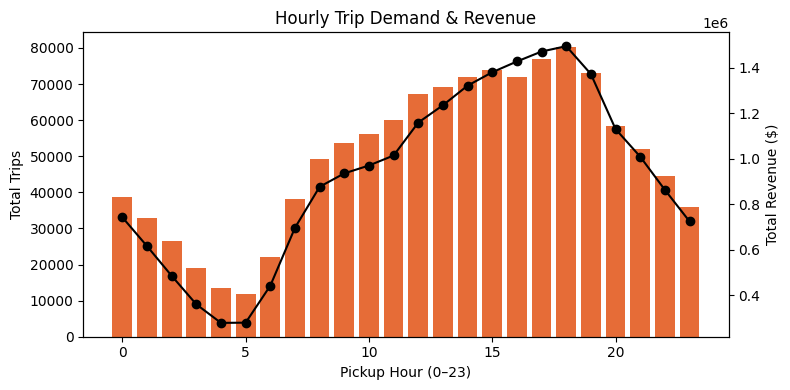

In [ ]:
### Trip Demand & Revenue by Hour

df_busy_hours = duckdb.sql("""
SELECT
  pickup_hour,
  COUNT(*) AS total_trips,
  SUM(total_amount) AS total_revenue
FROM trip_data
GROUP BY pickup_hour
ORDER BY pickup_hour
""").df()

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.bar(df_busy_hours['pickup_hour'], df_busy_hours['total_trips'], color='#E66C37', label='Total Trips')
ax1.set_ylabel('Total Trips', color='black')
ax1.tick_params(axis='y', labelcolor='black')


ax2 = ax1.twinx()
ax2.plot(df_busy_hours['pickup_hour'], df_busy_hours['total_revenue'], color='black', marker='o', label='Total Revenue')
ax2.set_ylabel('Total Revenue ($)', color='black')
ax2.tick_params(axis='y', labelcolor='black')


plt.title('Hourly Trip Demand & Revenue')
ax1.set_xlabel('Pickup Hour (0–23)')
fig.tight_layout()
plt.show()



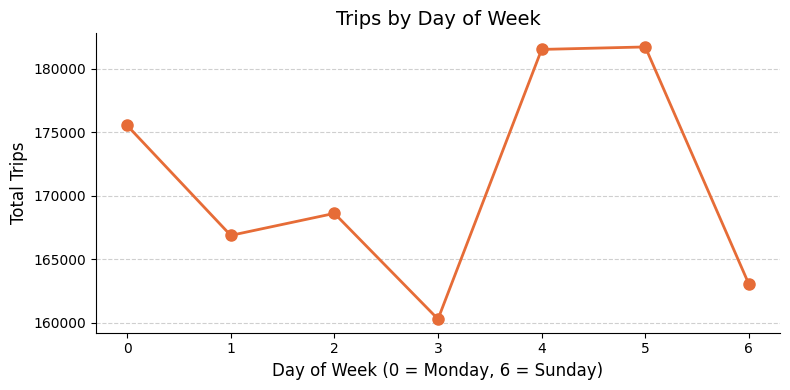

In [ ]:
# Number of trips by day

df_days = duckdb.sql("""
SELECT
    pickup_day_of_week,
    is_weekend,
    COUNT(*) AS total_trips
    FROM trip_data
    GROUP BY pickup_day_of_week, is_weekend
    ORDER BY pickup_day_of_week
    """).df()

plt.figure(figsize=(8, 4))
plt.plot(df_days['pickup_day_of_week'], df_days['total_trips'],
         color='#E66C37', marker='o', linewidth=2, markersize=8)

plt.title("Trips by Day of Week", fontsize=14)
plt.xlabel("Day of Week (0 = Monday, 6 = Sunday)", fontsize=12)
plt.ylabel("Total Trips", fontsize=12)
plt.xticks(df_days['pickup_day_of_week'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
###  Hourly patterns by day of week
# this help for identify in which day which time most trip , help in proper design reduce the idle
duckdb.sql(
    """SELECT pickup_hour,
            pickup_day_of_week,
                COUNT(*) as trip_count,
                    AVG(total_amount) as avg_revenue
                    FROM trip_data
                    GROUP BY pickup_hour, pickup_day_of_week
                    ORDER BY trip_count desc limit 7
                    """
).df()

,pickup_hour,pickup_day_of_week,trip_count,avg_revenue
0,18,1,14860,17.844816
1,1,2,14751,18.605896
2,2,2,13229,18.496998
3,0,2,13034,18.216224
4,19,1,12918,17.750373
5,17,1,12762,18.152293
6,18,0,12574,18.555301


In [ ]:
# supply demand gap analysis

duckdb.sql("""
    -- Peak hour zone imbalances (6-8 PM)
    WITH pickups AS (
        SELECT PU_Zone AS zone, pickup_hour, COUNT(*) AS pickup_count
        FROM trip_data
        WHERE pickup_hour BETWEEN 18 AND 20
        GROUP BY PU_Zone, pickup_hour
    ),
    dropoffs AS (
        SELECT DO_Zone AS zone, pickup_hour, COUNT(*) AS dropoff_count
        FROM trip_data
        WHERE pickup_hour BETWEEN 18 AND 20
        GROUP BY DO_Zone, pickup_hour
    ),
    zone_net_demand AS (
        SELECT
            COALESCE(p.zone, d.zone) AS zone,
            COALESCE(p.pickup_hour, d.pickup_hour) AS hour,
            COALESCE(p.pickup_count, 0) AS pickups,
            COALESCE(d.dropoff_count, 0) AS dropoffs,
            COALESCE(p.pickup_count, 0) - COALESCE(d.dropoff_count, 0) AS net_demand,
            CASE
                WHEN COALESCE(p.pickup_count, 0) > COALESCE(d.dropoff_count, 0)
                THEN 'UNDERSUPPLIED'
                ELSE 'OVERSUPPLIED'
            END AS zone_status
        FROM pickups p
        FULL OUTER JOIN dropoffs d
        ON p.zone = d.zone AND p.pickup_hour = d.pickup_hour
    )
    SELECT *
    FROM zone_net_demand
    ORDER BY net_demand DESC;
    """).df()

,zone,hour,pickups,dropoffs,net_demand,zone_status
0,JFK Airport,20,3759,314,3445,UNDERSUPPLIED
1,JFK Airport,19,3609,525,3084,UNDERSUPPLIED
2,JFK Airport,18,3476,754,2722,UNDERSUPPLIED
3,Midtown Center,18,4415,2044,2371,UNDERSUPPLIED
4,Midtown Center,19,3893,1865,2028,UNDERSUPPLIED
...,...,...,...,...,...,...
731,Clinton East,18,2085,2670,-585,OVERSUPPLIED
732,Yorkville East,20,444,1033,-589,OVERSUPPLIED
733,Upper West Side North,20,897,1488,-591,OVERSUPPLIED
734,None,18,0,663,-663,OVERSUPPLIED


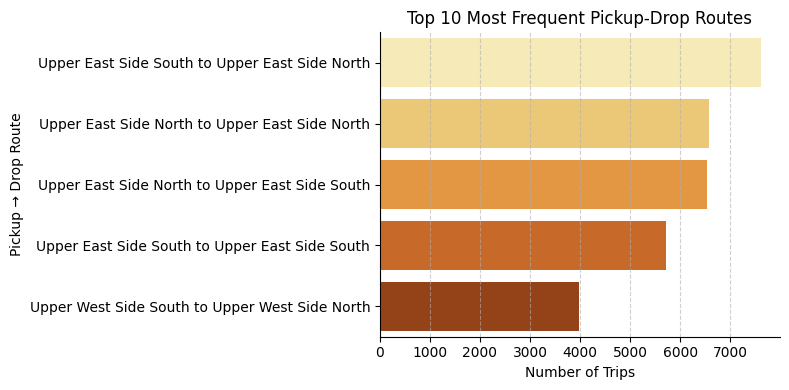

In [ ]:
#spatial analysis
# Most common pickup-drop pairs (OD matrix)
top_routes_df = duckdb.sql("""
    SELECT
    trip_route,
     COUNT(*) AS trip_count
    FROM trip_data
    WHERE trip_route IS NOT NULL
    GROUP BY trip_route
    ORDER BY trip_count DESC
    LIMIT 5
""").df()

plt.figure(figsize=(8, 4))
sns.barplot(data=top_routes_df, y='trip_route', x='trip_count', palette='YlOrBr')
plt.title('Top 10 Most Frequent Pickup-Drop Routes')
plt.xlabel('Number of Trips')
plt.ylabel('Pickup → Drop Route')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()


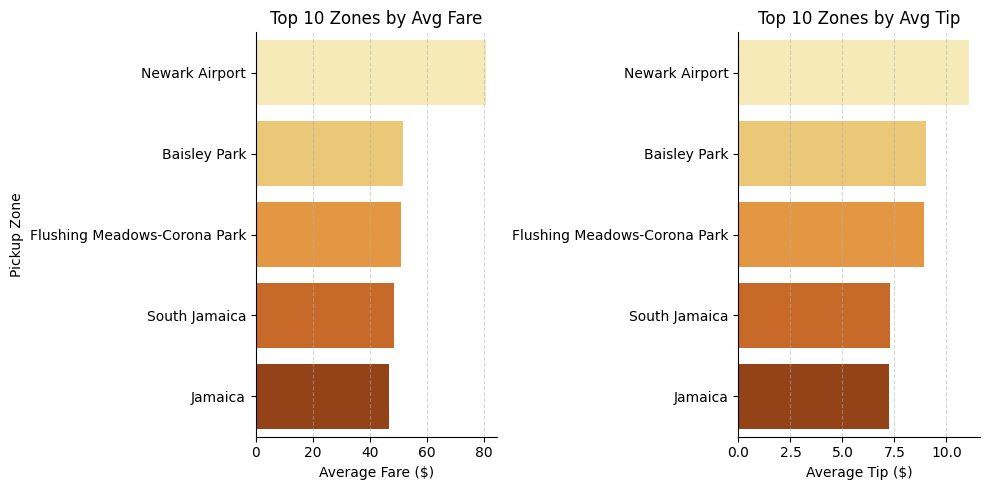

In [ ]:
# Aggregating fare, tip, and duration by pickup zone
zone_profit_df = duckdb.sql("""
    SELECT
            PU_Zone,
            COUNT(*) AS total_trips,
            ROUND(AVG(fare_amount), 2) AS avg_fare,
            ROUND(AVG(tip_amount), 2) AS avg_tip,
            ROUND(AVG(trip_duration_minutes), 2) AS avg_duration
            FROM trip_data
            WHERE PU_Zone IS NOT NULL
            GROUP BY PU_Zone
            HAVING total_trips >= 100
            ORDER BY avg_fare DESC
            LIMIT 5
            """).df()

# Plot average fare and tip by PU_Zone
plt.figure(figsize=(10, 5))

# Avg Fare
plt.subplot(1, 2, 1)
sns.barplot(data=zone_profit_df, x='avg_fare', y='PU_Zone', palette='YlOrBr')
plt.title('Top 10 Zones by Avg Fare')
plt.xlabel('Average Fare ($)')
plt.ylabel('Pickup Zone')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)

# Avg Tip
plt.subplot(1, 2, 2)
sns.barplot(data=zone_profit_df, x='avg_tip', y='PU_Zone', palette='YlOrBr')
plt.title('Top 10 Zones by Avg Tip')
plt.xlabel('Average Tip ($)')
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


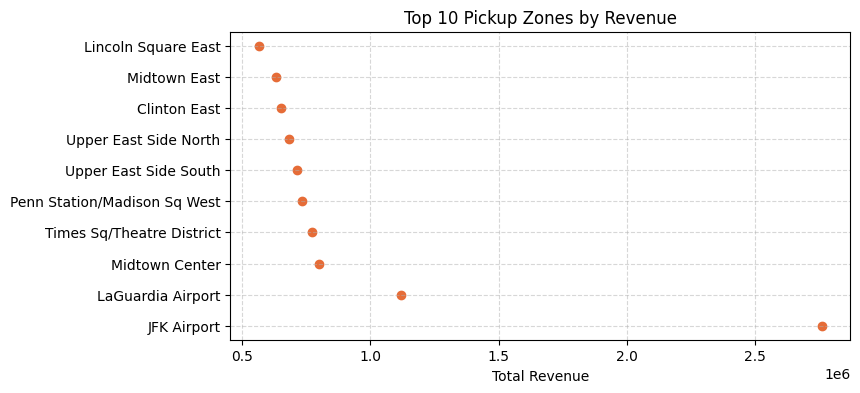

In [ ]:
import matplotlib.pyplot as plt

df = duckdb.sql("""
    SELECT PU_Zone, SUM(total_amount) AS total_revenue
    FROM trip_data
    GROUP BY PU_Zone
    ORDER BY total_revenue DESC
    LIMIT 10
    """).df()

plt.figure(figsize=(8,4))
plt.scatter(df['total_revenue'], df['PU_Zone'], color='#E66C37')
plt.xlabel("Total Revenue")
plt.title("Top 10 Pickup Zones by Revenue")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


<Axes: title={'center': 'Tip % vs Fare per Km'}, xlabel='fare_per_km', ylabel='tip_percent'>

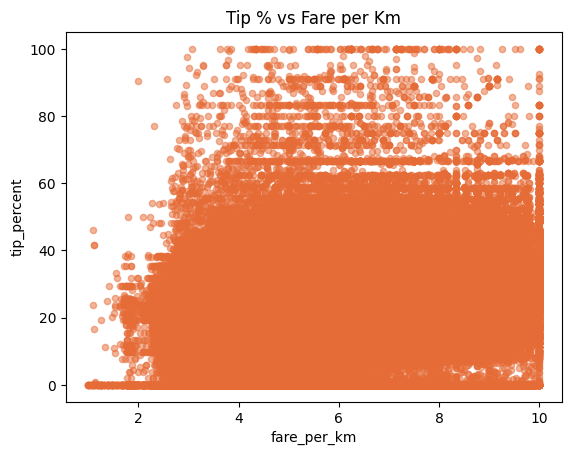

In [ ]:
###Profitability: Tip % vs Fare per Km
# See if longer, higher fare trips also bring better tips → helps in revenue optimization.

duckdb.sql("""
SELECT
    fare_per_km,
    tip_percent
    FROM trip_data
    WHERE fare_per_km BETWEEN 1 AND 10 AND tip_percent BETWEEN 0 AND 100
    """).df().plot.scatter(x='fare_per_km', y='tip_percent', alpha=0.5, color="#E66C37", title='Tip % vs Fare per Km')


In [ ]:
# revenue vs passenger count
duckdb.sql("""
SELECT
     passenger_count,
      COUNT(*) AS trip_count,
      AVG(total_amount) AS avg_total_amount,
        SUM(total_amount) AS total_revenue
        FROM trip_data
        GROUP BY passenger_count
        ORDER BY avg_total_amount desc limit 5
        """).df()


,passenger_count,trip_count,avg_total_amount,total_revenue
0,9.0,4,90.595000,3.623800e+02
1,7.0,5,73.856000,3.692800e+02
2,8.0,4,54.925000,2.197000e+02
3,4.0,30089,19.744523,5.940929e+05
4,2.0,193700,19.262229,3.731094e+06


<Axes: title={'center': 'Trip Distance vs Fare per Km'}, xlabel='trip_distance', ylabel='fare_per_km'>

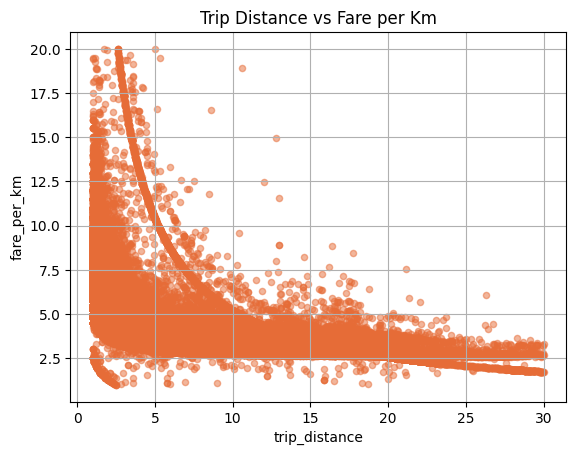

In [ ]:
duckdb.sql("""
    SELECT trip_distance, fare_per_km
        FROM trip_data
            WHERE trip_distance BETWEEN 1 AND 30 AND fare_per_km BETWEEN 1 AND 20
            """).df().plot.scatter(x='trip_distance',y='fare_per_km',
                         alpha=0.5,color='#E66C37',
                         title='Trip Distance vs Fare per Km',
                         grid=True)



## Statistical Analysis

In [ ]:
trip_df=duckdb.sql("select * from trip_data").df();

###  Correlation Analysis & Multi-collinearity Check

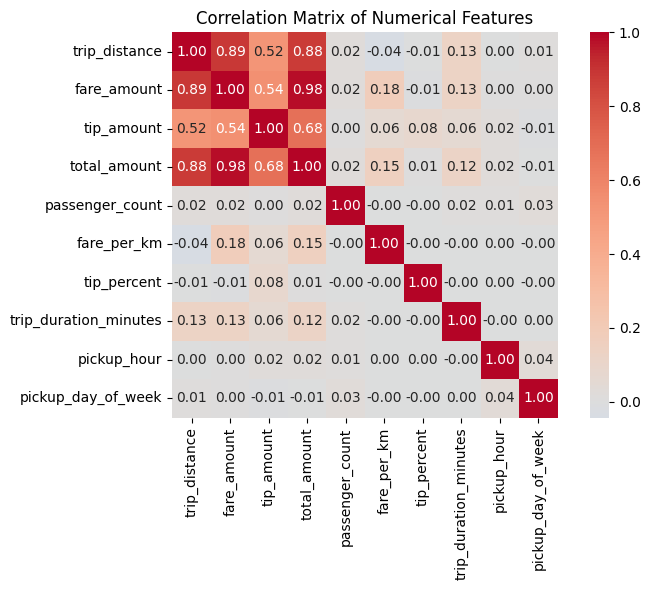

In [ ]:
numerical_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount',
                  'passenger_count', 'fare_per_km', 'tip_percent', 'trip_duration_minutes',
                  'pickup_hour', 'pickup_day_of_week']
correlation_matrix = trip_df[numerical_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [ ]:
# Find highly correlated pairs (above 0.7 or below -0.7)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            high_corr_pairs.append({
                'Feature1': correlation_matrix.columns[i],
                'Feature2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

print("Highly correlated feature pairs:")
for pair in high_corr_pairs:
    print(f"{pair['Feature1']} vs {pair['Feature2']}: {pair['Correlation']:.3f}")

Highly correlated feature pairs:
trip_distance vs fare_amount: 0.887
trip_distance vs total_amount: 0.879
fare_amount vs total_amount: 0.976


In [ ]:


# Check for multicollinearity using VIF
vif_data = trip_df[numerical_cols].dropna()

# Calculate VIF for each feature
vif_results = []
for i, col in enumerate(vif_data.columns):
    vif_value = variance_inflation_factor(vif_data.values, i)
    vif_results.append({'Feature': col, 'VIF': vif_value})

vif_df = pd.DataFrame(vif_results)
print("\nVariance Inflation Factor (VIF):")
print("VIF > 10 indicates high multicollinearity")
print(vif_df.sort_values('VIF', ascending=False))


Variance Inflation Factor (VIF):
VIF > 10 indicates high multicollinearity
                 Feature         VIF
3           total_amount  142.898067
1            fare_amount  103.155026
0          trip_distance    9.033508
2             tip_amount    6.197627
8            pickup_hour    4.084837
9     pickup_day_of_week    2.735326
4        passenger_count    2.454665
5            fare_per_km    1.283123
7  trip_duration_minutes    1.072513
6            tip_percent    1.013859


In [ ]:
features_to_remove_for_modeling = ['total_amount', 'fare_amount']
features_to_keep_for_modeling = [
    'trip_distance', 'tip_amount', 'fare_per_km', 'tip_percent',
     'trip_duration_minutes', 'pickup_hour', 'pickup_day_of_week',
    'passenger_count'
]

###  Statistical Significance Testing (ANOVA/T-tests)

In [ ]:


# T-test 1 -is weekend demand significantly different from weekday?
print("="*50)
print("TEST 1: Weekend vs Weekday Demand")
print("="*50)

# separate weekend and weekday data
weekend_data = trip_df[trip_df['is_weekend'] == 1]['total_amount']
weekday_data = trip_df[trip_df['is_weekend'] == 0]['total_amount']

# perform t-test
t_stat, p_value = ttest_ind(weekend_data, weekday_data)

print(f"Weekend trips average revenue: ${weekend_data.mean():.2f}")
print(f"Weekday trips average revenue: ${weekday_data.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print(" SIGNIFICANT: Weekend and weekday revenues are statistically different!")
else:
    print(" NOT SIGNIFICANT: No statistical difference between weekend and weekday revenues")

TEST 1: Weekend vs Weekday Demand
Weekend trips average revenue: $18.05
Weekday trips average revenue: $18.47
T-statistic: -14.1692
P-value: 0.000000
 SIGNIFICANT: Weekend and weekday revenues are statistically different!


In [ ]:
#  T-test 2 - Does rush hour affect fare per km?
print("\n" + "="*50)
print("TEST 2: Rush Hour vs Non-Rush Hour Pricing")
print("="*50)

rush_hour_fares = trip_df[trip_df['is_rush_hour'] == 1]['fare_per_km']
non_rush_fares = trip_df[trip_df['is_rush_hour'] == 0]['fare_per_km']

t_stat2, p_value2 = ttest_ind(rush_hour_fares, non_rush_fares)

print(f"Rush hour average fare per km: ${rush_hour_fares.mean():.2f}")
print(f"Non-rush hour average fare per km: ${non_rush_fares.mean():.2f}")
print(f"T-statistic: {t_stat2:.4f}")
print(f"P-value: {p_value2:.6f}")

if p_value2 < 0.05:
        print(" SIGNIFICANT: Rush hour pricing is statistically different!")
else:
        print(" NOT SIGNIFICANT: No statistical difference in rush hour pricing")


TEST 2: Rush Hour vs Non-Rush Hour Pricing
Rush hour average fare per km: $9.79
Non-rush hour average fare per km: $8.93
T-statistic: 4.7104
P-value: 0.000002
 SIGNIFICANT: Rush hour pricing is statistically different!


In [ ]:
# Test 3: ANOVA - Do different zones have significantly different revenues?
print("\n" + "="*50)
print("TEST 3: Zone-wise Revenue Differences (ANOVA)")
print("="*50)

# get top 5 zones by trip count for cleaner analysis
top_zones = trip_df['PU_Zone'].value_counts().head(5).index.tolist()
zone_revenue_groups = []

for zone in top_zones:
    zone_data = trip_df[trip_df['PU_Zone'] == zone]['total_amount']
    zone_revenue_groups.append(zone_data)
    print(f"{zone}: Average revenue ${zone_data.mean():.2f}, Count: {len(zone_data)}")


TEST 3: Zone-wise Revenue Differences (ANOVA)
Upper East Side South: Average revenue $13.98, Count: 50825
JFK Airport: Average revenue $51.94, Count: 50671
Midtown Center: Average revenue $16.70, Count: 47579
Upper East Side North: Average revenue $14.37, Count: 47536
Penn Station/Madison Sq West: Average revenue $16.72, Count: 43415


In [ ]:
# Perform one-way ANOVA
f_stat, p_value3 = f_oneway(*zone_revenue_groups)

print(f"\nF-statistic: {f_stat:.4f}")
print(f"P-value: {p_value3:.6f}")

if p_value3 < 0.05:
    print(" SIGNIFICANT: Different zones have statistically different revenues!")
    print(" Business insight: Zone-based pricing/resource allocation is justified!")
else:
    print(" NOT SIGNIFICANT: No statistical difference between zone revenues")



F-statistic: 69913.0263
P-value: 0.000000
 SIGNIFICANT: Different zones have statistically different revenues!
 Business insight: Zone-based pricing/resource allocation is justified!


In [ ]:
# Test 4: Chi-square test - Are rush hour patterns independent of day of week?
print("\n" + "="*50)
print("TEST 4: Rush Hour Independence from Day of Week")
print("="*50)

# Create contingency table
contingency_table = pd.crosstab(trip_df['pickup_day_of_week'], trip_df['is_rush_hour'])
print("Contingency Table:")
print(contingency_table)

# Perform chi-square test
chi2_stat, p_value4, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value4:.6f}")
print(f"Degrees of freedom: {dof}")

if p_value4 < 0.05:
      print(" SIGNIFICANT: Rush hour patterns depend on day of week!")
      print(" Business insight: Different days have different rush hour intensities!")
else:
      print(" NOT SIGNIFICANT: Rush hour patterns are independent of day of week")



TEST 4: Rush Hour Independence from Day of Week
Contingency Table:
is_rush_hour             0      1
pickup_day_of_week               
0                   117105  56343
1                   101858  63178
2                   125806  40464
3                   106289  52201
4                   123891  55894
5                   125402  54534
6                   111513  49480

Chi-square statistic: 7884.4542
P-value: 0.000000
Degrees of freedom: 6
 SIGNIFICANT: Rush hour patterns depend on day of week!
 Business insight: Different days have different rush hour intensities!


In [ ]:
# Summary of all tests
print("\n" + "="*60)
print("SUMMARY OF STATISTICAL TESTS")
print("="*60)
tests_summary = [
    ("Weekend vs Weekday Revenue", p_value < 0.05, p_value),
        ("Rush Hour vs Non-Rush Pricing", p_value2 < 0.05, p_value2),
            ("Zone Revenue Differences", p_value3 < 0.05, p_value3),
                ("Rush Hour Day Independence", p_value4 < 0.05, p_value4)
                ]

for test_name, is_significant, p_val in tests_summary:
     status = "SIGNIFICANT" if is_significant else "NOT SIGNIFICANT"
     print(f"{test_name}: {status} (p={p_val:.6f})")


SUMMARY OF STATISTICAL TESTS
Weekend vs Weekday Revenue: SIGNIFICANT (p=0.000000)
Rush Hour vs Non-Rush Pricing: SIGNIFICANT (p=0.000002)
Zone Revenue Differences: SIGNIFICANT (p=0.000000)
Rush Hour Day Independence: SIGNIFICANT (p=0.000000)


<br>📊 STRATEGIC RECOMMENDATIONS:
Immediate Actions (High Priority):
Fix surge pricing strategy - Rush hours should command premium rates
Implement zone-based pricing - Charge more in high-revenue zones
Weekend-specific operations - Different strategies for weekends

In [ ]:
# Test 1: Check if trip volume follows Poisson distribution (common for count data)
print("="*60)
print("TEST 1: Distribution Analysis for Trip Volume")
print("="*60)

# Create hourly trip counts
hourly_trips = trip_df.groupby(['pickup_hour']).size().values

print(f"Trip volume statistics:")
print(f"Mean: {hourly_trips.mean():.2f}")
print(f"Variance: {hourly_trips.var():.2f}")
print(f"Standard deviation: {hourly_trips.std():.2f}")
print(f"Variance/Mean ratio: {hourly_trips.var()/hourly_trips.mean():.2f}")
print("(For Poisson: variance should ≈ mean, ratio ≈ 1.0)")

# Test for Poisson distribution
# For Poisson test, we'll use Kolmogorov-Smirnov test
estimated_lambda = hourly_trips.mean()
ks_stat, p_value_poisson = stats.kstest(hourly_trips,
                                        lambda x: poisson.cdf(x, estimated_lambda))

print(f"\nPoisson Distribution Test:")
print(f"Estimated λ (lambda): {estimated_lambda:.2f}")
print(f"KS statistic: {ks_stat:.4f}")
print(f"P-value: {p_value_poisson:.6f}")

if p_value_poisson > 0.05:
  print(" FOLLOWS POISSON: Use Poisson regression for demand forecasting!")
else:
  print(" NOT POISSON: Consider Negative Binomial or other models")


TEST 1: Distribution Analysis for Trip Volume
Trip volume statistics:
Mean: 49331.58
Variance: 428596028.24
Standard deviation: 20702.56
Variance/Mean ratio: 8688.07
(For Poisson: variance should ≈ mean, ratio ≈ 1.0)

Poisson Distribution Test:
Estimated λ (lambda): 49331.58
KS statistic: 0.5417
P-value: 0.000000
 NOT POISSON: Consider Negative Binomial or other models



TEST 2: Normality Test for Fare Amount
Fare amount statistics (cleaned):
Mean: $12.58
Median: $9.00
Std: $11.24
Skewness: 2.588
Kurtosis: 7.164

Shapiro-Wilk Test (sample of 5000 trips):
Statistic: 0.6711
P-value: 0.000000

Jarque-Bera Test:
Statistic: 3839297.0615
P-value: 0.000000
❌ NOT NORMAL: Consider log-transformation or non-parametric methods


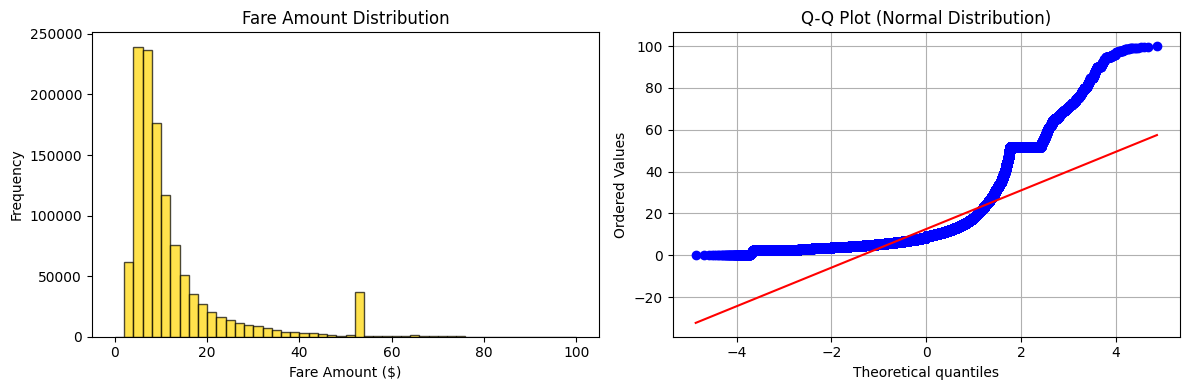

In [ ]:
# Test 2: Normality test for fare_amount
print("\n" + "="*60)
print("TEST 2: Normality Test for Fare Amount")
print("="*60)

# Clean data (remove extreme outliers for cleaner test)
fare_clean = trip_df[(trip_df['fare_amount'] > 0) & (trip_df['fare_amount'] < 100)]['fare_amount']

print(f"Fare amount statistics (cleaned):")
print(f"Mean: ${fare_clean.mean():.2f}")
print(f"Median: ${fare_clean.median():.2f}")
print(f"Std: ${fare_clean.std():.2f}")
print(f"Skewness: {fare_clean.skew():.3f}")
print(f"Kurtosis: {fare_clean.kurtosis():.3f}")

# Shapiro-Wilk test (sample size limit)
if len(fare_clean) > 5000:
    fare_sample = fare_clean.sample(5000, random_state=42)
else:
    fare_sample = fare_clean

shapiro_stat, shapiro_p = shapiro(fare_sample)
print(f"\nShapiro-Wilk Test (sample of {len(fare_sample)} trips):")
print(f"Statistic: {shapiro_stat:.4f}")
print(f"P-value: {shapiro_p:.6f}")

# Jarque-Bera test (better for large samples)
jb_stat, jb_p = jarque_bera(fare_clean)
print(f"\nJarque-Bera Test:")
print(f"Statistic: {jb_stat:.4f}")
print(f"P-value: {jb_p:.6f}")

if shapiro_p > 0.05 and jb_p > 0.05:
    print(" NORMAL DISTRIBUTION: Use linear regression, t-tests valid")
else:
    print(" NOT NORMAL: Consider log-transformation or non-parametric methods")

    # Visualize normality
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(fare_clean, bins=50, alpha=0.7, color='Gold', edgecolor='black')
    plt.title('Fare Amount Distribution')
    plt.xlabel('Fare Amount ($)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    stats.probplot(fare_clean, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Normal Distribution)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Test 3: Outlier Detection
print("\n" + "="*60)
print("TEST 3: Outlier Detection Analysis")
print("="*60)

#  IQR Method for fare_amount
Q1 = trip_df['fare_amount'].quantile(0.25)
Q3 = trip_df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = trip_df[(trip_df['fare_amount'] < lower_bound) | (trip_df['fare_amount'] > upper_bound)]

print(f"IQR Method - Fare Amount:")
print(f"Q1: ${Q1:.2f}, Q3: ${Q3:.2f}, IQR: ${IQR:.2f}")
print(f"Outlier bounds: ${lower_bound:.2f} to ${upper_bound:.2f}")
print(f"Number of outliers: {len(iqr_outliers):,} ({len(iqr_outliers)/len(trip_df)*100:.1f}% of data)")


TEST 3: Outlier Detection Analysis
IQR Method - Fare Amount:
Q1: $6.00, Q3: $13.50, IQR: $7.50
Outlier bounds: $-5.25 to $24.75
Number of outliers: 121,052 (10.2% of data)


In [ ]:
#  Z-score method for trip_distance
z_scores = np.abs(stats.zscore(trip_df['trip_distance']))
z_outliers = trip_df[z_scores > 3]

print(f"\nZ-score Method - Trip Distance:")
print(f"Outliers (|z| > 3): {len(z_outliers):,} ({len(z_outliers)/len(trip_df)*100:.1f}% of data)")


Z-score Method - Trip Distance:
Outliers (|z| > 3): 44,829 (3.8% of data)


In [ ]:
#  Isolation Forest for multivariate outliers
print(f"\nIsolation Forest - Multivariate Outliers:")
# Select features for outlier detection
outlier_features = ['trip_distance', 'fare_amount', 'trip_duration_minutes', 'tip_amount']
outlier_data = trip_df[outlier_features].dropna()

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_predictions = iso_forest.fit_predict(outlier_data)

multivariate_outliers = outlier_data[outlier_predictions == -1]
print(f"Multivariate outliers detected: {len(multivariate_outliers):,} ({len(multivariate_outliers)/len(outlier_data)*100:.1f}% of data)")

# Analyze outlier characteristics
print(f"\nOutlier Characteristics (IQR method):")
if len(iqr_outliers) > 0:
    print(f"Average fare of outliers: ${iqr_outliers['fare_amount'].mean():.2f}")
    print(f"Max fare outlier: ${iqr_outliers['fare_amount'].max():.2f}")
    print(f"Most common outlier zones:")
    print(iqr_outliers['PU_Zone'].value_counts().head(3))


Isolation Forest - Multivariate Outliers:
Multivariate outliers detected: 59,198 (5.0% of data)

Outlier Characteristics (IQR method):
Average fare of outliers: $40.59
Max fare outlier: $1238.00
Most common outlier zones:
PU_Zone
JFK Airport                  41462
LaGuardia Airport            19344
Times Sq/Theatre District     3973
Name: count, dtype: int64


In [ ]:
print("\n" + "="*60)
print("DISTRIBUTION ANALYSIS SUMMARY")
print("="*60)

distribution_summary = [
    ("Trip Volume Distribution", "Poisson" if p_value_poisson > 0.05 else "Non-Poisson", p_value_poisson),
        ("Fare Amount Normality", "Normal" if jb_p > 0.05 else "Non-Normal", jb_p),
            ("Outlier Percentage (IQR)", f"{len(iqr_outliers)/len(trip_df)*100:.1f}%", None),
                ("Outlier Percentage (Multivariate)", f"{len(multivariate_outliers)/len(outlier_data)*100:.1f}%", None)
                ]

for analysis, result, p_val in distribution_summary:
       if p_val is not None:
           print(f"{analysis}: {result} (p={p_val:.6f})")
       else:
           print(f"{analysis}: {result}")


DISTRIBUTION ANALYSIS SUMMARY
Trip Volume Distribution: Non-Poisson (p=0.000000)
Fare Amount Normality: Non-Normal (p=0.000000)
Outlier Percentage (IQR): 10.2%
Outlier Percentage (Multivariate): 5.0%


# **Revenue Prediction**


### Data Preparation

In [ ]:
# Based on your VIF analysis:
features_to_remove_for_modeling = ['total_amount', 'fare_amount']
features_to_keep_for_modeling = [
    'trip_distance', 'tip_amount', 'fare_per_km', 'tip_percent',
    'trip_duration_minutes', 'pickup_hour', 'pickup_day_of_week',
    'passenger_count','trip_route'
    ]

In [ ]:
df = trip_df.copy()
original_shape = len(df)

In [ ]:
# Remove only impossible values (not outliers)
df = df[
    (df['fare_amount'] > 0) &           # Positive fare
    (df['trip_distance'] > 0) &         # Positive distance
    (df['total_amount'] > 0) &          # Positive total
    (df['tip_amount'] >= 0) &           # Non-negative tips
    (df['passenger_count'] > 0) &       # At least 1 passenger
    (df['trip_duration_minutes'] > 0)   # Positive duration
    ]

In [ ]:
# create target variable
df['revenue_per_minute'] = df['total_amount'] / df['trip_duration_minutes']
target_variable = 'revenue_per_minute'

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['revenue_per_minute'])

In [ ]:
print(df[target_variable].describe())

count    1.150575e+06
mean     2.150380e+00
std      1.637593e+01
min      1.964096e-03
25%      1.233735e+00
50%      1.515400e+00
75%      1.940668e+00
max      3.129000e+03
Name: revenue_per_minute, dtype: float64


In [ ]:
df_model = df[features_to_keep_for_modeling + [target_variable]].dropna()

In [ ]:
# Show outlier statistics we're keeping
print(f"\nOutlier statistics we're KEEPING:")
print(f"Revenue per minute range: ${df_model[target_variable].min():.2f} to ${df_model[target_variable].max():.2f}")
print(f"Trip distance range: {df_model['trip_distance'].min():.1f} to {df_model['trip_distance'].max():.1f} miles")
print(f"Tip amount range: ${df_model['tip_amount'].min():.2f} to ${df_model['tip_amount'].max():.2f}")


Outlier statistics we're KEEPING:
Revenue per minute range: $0.00 to $3129.00
Trip distance range: 0.0 to 86.0 miles
Tip amount range: $0.00 to $450.00


In [ ]:
print(f"\nFeature correlation with target:")
correlations = df_model[features_to_keep_for_modeling].corrwith(df_model[target_variable])
print(correlations.sort_values(ascending=False))


Feature correlation with target:


ValueError: could not convert string to float: 'Clinton East to Flatiron'

###Feature Engineering


In [ ]:
# trip efficiency (distance per minute)
df_model['distance_per_minute'] = df_model['trip_distance'] / df_model['trip_duration_minutes']

In [ ]:
# high-value trip indicator
df_model['is_high_value'] = (df_model['tip_amount'] > df_model['tip_amount'].quantile(0.75)).astype(int)

In [ ]:
# busyday Like Friday & Saturday
df_model['is_busyday'] = (df_model['pickup_day_of_week'].isin([4, 5])).astype(int)

In [ ]:
# peak hours (morning and evening rush)
df_model['is_peak_hour'] = (
    ((df_model['pickup_hour'] >= 7) & (df_model['pickup_hour'] <= 9)) |
    ((df_model['pickup_hour'] >= 17) & (df_model['pickup_hour'] <= 19))).astype(int)

In [ ]:
features_final = [
    'trip_distance', 'tip_amount', 'fare_per_km', 'tip_percent',
    'trip_duration_minutes', 'pickup_hour', 'pickup_day_of_week',
    'passenger_count' ,'distance_per_minute', 'is_high_value', 'is_busyday', 'is_peak_hour']

In [ ]:
route_target_mean = df.groupby('trip_route')['revenue_per_minute'].mean().to_dict()
df['trip_route_encoded'] = df['trip_route'].map(route_target_mean)


df[['trip_route', 'trip_route_encoded']].head()


## Data Splitting

In [ ]:
X = df_model[features_final]
y = df_model['revenue_per_minute']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)

In [ ]:
train_correlations = X_train.corrwith(y_train)
print(train_correlations.sort_values(ascending=False))

fare_per_km              0.535693
distance_per_minute      0.253939
tip_amount               0.060096
tip_percent              0.034438
is_high_value            0.015912
pickup_day_of_week       0.003379
is_peak_hour            -0.000940
pickup_hour             -0.002413
passenger_count         -0.002641
is_busyday              -0.002737
trip_duration_minutes   -0.013920
trip_distance           -0.014917
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import time

In [ ]:
models = {
      'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
      'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
      'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
       }

In [ ]:
results = {}

for name, model in models.items():
    print(f"\n Training {name}...")
    start_time = time.time()

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # evaluation metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    training_time = time.time() - start_time

    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'training_time': training_time,
        'predictions': y_pred_test
    }

    print(f" {name} completed in {training_time:.2f} seconds")
    print(f"   Train MAE: ${train_mae:.3f} | Test MAE: ${test_mae:.3f}")
    print(f"   Train R²: {train_r2:.3f} | Test R²: {test_r2:.3f}")

Training Random Forest...  Random Forest completed in 1020.17 seconds
   Train MAE: $0.044 | Test MAE: $0.115
   Train R²: 0.942 | Test R²: 0.906

Training Gradient Boosting...  Gradient Boosting completed in 285.50 seconds
   Train MAE: $0.303 | Test MAE: $0.327
   Train R²: 0.973 | Test R²: 0.949

Training XGBoost...  XGBoost completed in 9.81 seconds
   Train MAE: $0.269 | Test MAE: $0.477
   Train R²: 0.883 | Test R²: 0.572



In [ ]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test MAE ($)': [f"${results[name]['test_mae']:.3f}" for name in results.keys()],
    'Test R²': [f"{results[name]['test_r2']:.3f}" for name in results.keys()],
    'Test RMSE ($)': [f"${results[name]['test_rmse']:.3f}" for name in results.keys()],
    'Training Time (s)': [f"{results[name]['training_time']:.2f}" for name in results.keys()]
})

print(comparison_df.to_string(index=False))

# Find best model (lowest test MAE)
best_model_name = min(results.keys(), key=lambda x: results[x]['test_mae'])
best_model = results[best_model_name]['model']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Best Test MAE: ${results[best_model_name]['test_mae']:.3f}")
print(f"   Best Test R²: {results[best_model_name]['test_r2']:.3f}")

            Model Test MAE ($) Test R² Test RMSE ($) Training Time (s)
    Random Forest       $0.115   0.906        $4.859           1020.17
Gradient Boosting       $0.321   0.934        $4.073            233.01
          XGBoost       $0.434   0.493       $11.301              7.11

 BEST MODEL: Random Forest
   Best Test MAE: $0.115
   Best Test R²: 0.906


# **MODEL 2: Hourly Zone-Based Taxi Demand Forecasting**

### Feature Engineering

In [ ]:
#Create is_busyday feature (Friday and Saturday)
trip_df['is_busyday'] = (trip_df['pickup_day_of_week'].isin([4, 5])).astype(int)

In [ ]:
# Extract date from datetime column
trip_df['pickup_date'] = trip_df['tpep_pickup_datetime'].dt.date

demand_df = trip_df.groupby(['PU_Zone', 'pickup_date', 'pickup_hour']).agg({
    'tpep_pickup_datetime': 'count',
    'is_busyday': 'first',
    'pickup_day_of_week': 'first',
    'is_rush_hour': 'first'
}).reset_index()


demand_df.rename(columns={'tpep_pickup_datetime': 'demand'}, inplace=True)

In [ ]:
# Create lag features

# Sort by zone and time first
demand_df = demand_df.sort_values(['PU_Zone', 'pickup_date', 'pickup_hour'])

# Add lag features for each zone
demand_df['demand_last_hour'] = demand_df.groupby('PU_Zone')['demand'].shift(1)
demand_df['demand_yesterday_same_hour'] = demand_df.groupby('PU_Zone')['demand'].shift(24)
demand_df['demand_avg_last_3hours'] = demand_df.groupby('PU_Zone')['demand'].rolling(3).mean().shift(1).values

# Fill missing values with 0
demand_df[['demand_last_hour', 'demand_yesterday_same_hour', 'demand_avg_last_3hours']] = demand_df[['demand_last_hour', 'demand_yesterday_same_hour', 'demand_avg_last_3hours']].fillna(0)


In [ ]:
feature_columns = [
    'PU_Zone',
    'pickup_hour',
    'pickup_day_of_week',
    'is_busyday',
    'is_rush_hour',
    'demand_last_hour',
    'demand_yesterday_same_hour',
    'demand_avg_last_3hours'
]


model_df = demand_df[feature_columns + ['demand']].copy()


In [ ]:
# check data quality
print("Data Quality Check:")
print(f"Total records: {len(model_df)}")
print(f"Records with missing values: {model_df.isnull().sum().sum()}")

print("\nBasic Statistics:")
print(model_df['demand'].describe())

print("\nFeature Summary:")
print(f"Unique zones: {model_df['PU_Zone'].nunique()}")
print(f"Hours covered: {model_df['pickup_hour'].nunique()}")
print(f"Busy days percentage: {model_df['is_busyday'].mean()*100:.1f}%")
print(f"Rush hours percentage: {model_df['is_rush_hour'].mean()*100:.1f}%")

Data Quality Check:
Total records: 18880
Records with missing values: 0

Basic Statistics:
count    18880.000000
mean        62.709640
std        110.591326
min          1.000000
25%          2.000000
50%          8.000000
75%         73.000000
max        950.000000
Name: demand, dtype: float64

Feature Summary:
Unique zones: 247
Hours covered: 24
Busy days percentage: 28.3%
Rush hours percentage: 22.4%


In [ ]:
clean_df = model_df.dropna()


X = clean_df[feature_columns].copy()
y = clean_df['demand']

# Convert zone to dummy variables
X_encoded = pd.get_dummies(X, columns=['PU_Zone'])

In [ ]:
# Quick Random Forest to see what features matter most
rf_temp = RandomForestRegressor(n_estimators=50, random_state=42)
rf_temp.fit(X_encoded, y)


importance_df = pd.DataFrame({
    'feature': X_encoded.columns,
        'importance': rf_temp.feature_importances_
        }).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

Top 10 Most Important Features:
                                  feature  importance
4                        demand_last_hour    0.902277
5              demand_yesterday_same_hour    0.026414
6                  demand_avg_last_3hours    0.022493
0                             pickup_hour    0.017577
1                      pickup_day_of_week    0.004550
80                   PU_Zone_East Village    0.002776
229         PU_Zone_Upper East Side South    0.002002
139           PU_Zone_Lincoln Square East    0.001488
182  PU_Zone_Penn Station/Madison Sq West    0.001249
228         PU_Zone_Upper East Side North    0.001051


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X_encoded, y,  test_size=0.2, random_state=42)

In [ ]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

In [ ]:
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
    r2 = r2_score(y_true, y_pred)
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

results = []

results.append(calculate_metrics(y_test, rf_pred, 'Random Forest'))
results.append(calculate_metrics(y_test, xgb_pred, 'XGBoost'))
results.append(calculate_metrics(y_test, gb_pred, 'Gradient Boosting'))


results_df = pd.DataFrame(results)

print("\nMODEL COMPARISON:")
print(results_df.round(2))

best_model_idx = results_df['MAE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_mae = results_df.loc[best_model_idx, 'MAE']
best_r2 = results_df.loc[best_model_idx, 'R2']

print(f"\n BEST MODEL: {best_model_name}")
print(f"Best MAE: {best_mae:.2f} trips")
print(f"Best R² Score: {best_r2:.3f}")

if best_model_name == 'Random Forest':
    best_model = rf_model
    best_pred = rf_pred
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    best_pred = xgb_pred
else:
    best_model = gb_model
    best_pred = gb_pred

print(f"\n Selected {best_model_name} as final model")

MODEL COMPARISON:
             Model         MAE     RMSE     MAPE    R2
0     Random Forest      12.59    28.78     43.70   0.63
1            XGBoost     15.54    37.90     50.48   0.91
2  Gradient Boosting     9.53    25.14     50.89   0.84

 BEST MODEL: Gradient Boosting
Best MAE: 9.53 trips
Best R² Score: 0.84

 Selected Gradient Boosting as final model


In [ ]:
def predict_demand(zone, hour, day_of_week, is_busyday, is_rush_hour,
                   demand_last_hour=0, demand_yesterday=0, demand_avg_3hr=0):
    """
    Predict taxi demand for given inputs

    Parameters:
        - zone: Pickup zone (string)
        - hour: Hour of day (0-23)
        - day_of_week: Day of week (0-6, where 0=Monday)
        - is_busyday: 1 if Friday/Saturday, 0 otherwise
        - is_rush_hour: 1 if rush hour, 0 otherwise
        - demand_last_hour: Trips in last hour (optional)
        - demand_yesterday: Trips same hour yesterday (optional)
        - demand_avg_3hr: Average trips last 3 hours (optional)
    """

    # Create input dataframe
    input_data = pd.DataFrame({
        'pickup_hour': [hour],
        'pickup_day_of_week': [day_of_week],
        'is_busyday': [is_busyday],
        'is_rush_hour': [is_rush_hour],
        'demand_last_hour': [demand_last_hour],
        'demand_yesterday_same_hour': [demand_yesterday],
        'demand_avg_last_3hours': [demand_avg_3hr]
    })

    for col in X_encoded.columns:
        if col.startswith('PU_Zone_'):
            if col == f'PU_Zone_{zone}':
                input_data[col] = 1
            else:
                input_data[col] = 0
        elif col not in input_data.columns:
            input_data[col] = 0

    # Reorder columns to match training data
    input_data = input_data[X_encoded.columns]

    # Make prediction
    prediction = best_model.predict(input_data)[0]

    return max(0, round(prediction))

print("Prediction pipeline created!")

✅ Prediction pipeline created!


In [ ]:
# testing ex1
pred1 = predict_demand(
    zone='Manhattan',
    hour=17,
    day_of_week=4,
    is_busyday=1,
    is_rush_hour=1,
    demand_last_hour=25,
    demand_yesterday=30,
    demand_avg_3hr=22
)
print(f"Example  - Manhattan, 5PM Friday (rush): {pred1} trips predicted")


🧪 TESTING PREDICTION PIPELINE:
Example 1 - Manhattan, 5PM Friday (rush): 29 trips predicted


In [ ]:
# testig ex 2
pred2 = predict_demand(
    zone='Queens',
    hour=2,
    day_of_week=1,
    is_busyday=0,
    is_rush_hour=0,
    demand_last_hour=3,
    demand_yesterday=5,
    demand_avg_3hr=4
)
print(f"Example  - Queens, 2AM Tuesday (quiet): {pred2} trips predicted")

Example 2 - Queens, 2AM Tuesday (quiet): 2 trips predicted
